In [16]:
import findspark
findspark.init()

In [17]:
!python --version

Python 3.9.4


In [18]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("HDFS")
    .getOrCreate()
)

In [5]:
police_df = (
    spark.read
    .option("header", "true")
    .option("inferschema", "true")
    .csv('hdfs://localhost:8020/user/project/input/police_stations.csv')
)
police_df.printSchema()

root
 |-- DISTRICT: string (nullable = true)
 |-- DISTRICT NAME: string (nullable = true)
 |-- ADDRESS: string (nullable = true)
 |-- CITY: string (nullable = true)
 |-- STATE: string (nullable = true)
 |-- ZIP: integer (nullable = true)
 |-- WEBSITE: string (nullable = true)
 |-- PHONE: string (nullable = true)
 |-- FAX: string (nullable = true)
 |-- TTY: string (nullable = true)
 |-- X COORDINATE: double (nullable = true)
 |-- Y COORDINATE: double (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- LOCATION: string (nullable = true)



In [15]:
police_df.show()

+--------------------+-----------------+--------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+
|            DISTRICT|    DISTRICT NAME|             ADDRESS|   CITY|STATE|  ZIP|             WEBSITE|       PHONE|         FAX|         TTY|X COORDINATE|Y COORDINATE|   LATITUDE|   LONGITUDE|            LOCATION|
+--------------------+-----------------+--------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+
|        Headquarters|     Headquarters| 3510 S Michigan Ave|Chicago|   IL|60653|http://home.chica...|        null|        null|        null| 1177731.401| 1881697.404|41.83070169|-87.62339535|(41.8307016873, -...|
|                  18|       Near North|  1160 N Larrabee St|Chicago|   IL|60610|http://home.chica...|312-742-5870|312-742-5771|312-742-5773| 11

In [11]:
police_df.createOrReplaceTempView("police")

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession

from os.path import abspath
warehouse_location = abspath('spark-warehouse')

spark2 = SparkSession \
    .builder \
    .appName("Python Spark SQL Hive integration example") \
    .config("spark.sql.warehouse.dir", "hdfs://node1/user/hive/warehouse/speed_camera_violations_fix") \
    .enableHiveSupport() \
    .getOrCreate()

23/01/13 01:17:39 WARN util.Utils: Your hostname, node1 resolves to a loopback address: 127.0.0.1; using 10.0.2.15 instead (on interface enp0s3)
23/01/13 01:17:39 WARN util.Utils: Set SPARK_LOCAL_IP if you need to bind to another address
23/01/13 01:17:40 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
speed_camera = spark2.sql("select * from speed_camera_violations_fix")

In [12]:
speed_camera.createOrReplaceTempView("speed_camera")

In [160]:
speed_camera.printSchema()

root
 |-- address: string (nullable = true)
 |-- camera_id: string (nullable = true)
 |-- violation_date: string (nullable = true)
 |-- violations: integer (nullable = true)
 |-- x_cord: float (nullable = true)
 |-- y_cord: float (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)



In [126]:
df = spark.sql("SELECT longitude, latitude, `DISTRICT NAME` FROM police where longitude is not null ")


In [144]:
import pandas as pd

In [134]:
long = df.select("longitude").rdd.flatMap(lambda x: x).collect()

In [135]:
lat = df.select("latitude").rdd.flatMap(lambda x: x).collect()

In [139]:
dis_name = df.select("DISTRICT NAME").rdd.flatMap(lambda x: x).collect()

In [145]:
p_df = pd.DataFrame(list(zip(long, lat,dis_name )),columns =['longitude', 'latitude','name'])

In [209]:
tables = []
for i in range(22):
    long = p_df.loc[i][0]
    lat = p_df.loc[i][1]
    dist = p_df.loc[i][2]
    script = "abs(longitude - " + str(long) + " + latitude - " + str(lat) + ")"
    print(dist)
    t=spark.sql("SELECT distinct camera_id, longitude, latitude, " + script + "as distance, '" + dist +\
                "' as location FROM speed_camera where longitude is not null ")
    tables.append(t)
    if i == 0:
        df2 = t
    else:
        df2 = df2.union(tables[i])
        

Headquarters
Near North
Town Hall
Lincoln
Morgan Park
Rogers Park
Grand Central
Central
Wentworth
Grand Crossing
South Chicago
Calumet
Gresham
Englewood
Chicago Lawn
Deering
Ogden
Harrison
Shakespeare
Austin
Jefferson Park
Albany Park


In [210]:
df2.createOrReplaceTempView("test1")

In [218]:
spark.sql("select * from test1 limit 2").show()

+---------+----------+---------+-------------------+------------+
|camera_id| longitude| latitude|           distance|    location|
+---------+----------+---------+-------------------+------------+
|   CHI114|-87.748184|41.992092|0.03660158846679451|Headquarters|
|   CHI101| -87.57631|41.760006|0.02360959317383049|Headquarters|
+---------+----------+---------+-------------------+------------+



In [207]:
for i in range(1,22):
    tables[0].union(tables[i]).createOrReplaceTempView("test1")

In [238]:
camera_locations = spark.sql("select location, t1.camera_id, t1.min_dist from test1 join (SELECT camera_id , min(distance)  \
          as min_dist FROM test1 group by camera_id ) t1 on test1.distance = t1. min_dist and test1.camera_id = t1.camera_id ")
          
          

In [240]:
camera_locations.createOrReplaceTempView("camera_locations")

In [243]:
speed_camera2 = spark.sql("SELECT address, s.camera_id,violation_date,violations,location,\
min_dist FROM speed_camera s left join camera_locations c on s.camera_id = c.camera_id")




In [244]:
camera_locations.write.csv("hdfs://node1:8020/user/project/output/camera_location.csv")

In [245]:
speed_camera2.write.csv("hdfs://node1:8020/user/project/output/speed_camera2.csv")

In [246]:
speed_camera2.createOrReplaceTempView("speed_camera2")

In [250]:
spark.sql("select min(min_dist), max(min_dist) from speed_camera2").show()

+--------------------+-------------------+
|       min(min_dist)|      max(min_dist)|
+--------------------+-------------------+
|8.247674804806593E-5|0.04891918125976957|
+--------------------+-------------------+



In [264]:
speed_camera3 = spark.sql("select address, violation_date, violations,location, \
(min_dist - 8.247674804806593/100000)/ (0.04891918125976957 - 8.247674804806593/100000) as dist  from speed_camera2")

In [272]:
speed_camera3.createOrReplaceTempView("speed_camera3")

In [273]:
speed_camera4 = spark.sql("select *, case\
           when ceil(dist*10) <=10    then  ceil(dist*10)\
           else 10\
      end DistRange from speed_camera3")

In [274]:
plot_df1 = speed_camera4.groupBy('DistRange').agg({'violations':'sum'})

In [276]:
import matplotlib.pyplot as plt

In [279]:
x = plot_df1.select('DistRange').rdd.flatMap(lambda x: x).collect()

In [280]:
y = plot_df1.select("sum(violations)").rdd.flatMap(lambda x: x).collect()

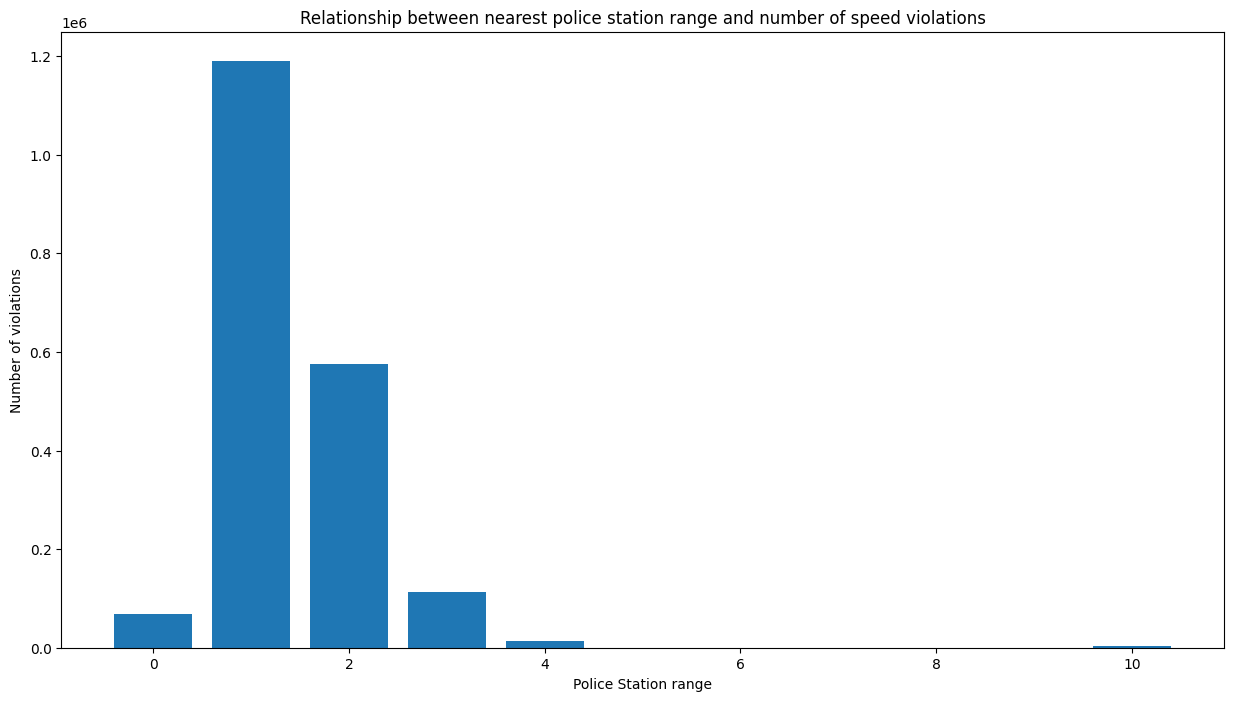

23/01/13 04:39:59 WARN hdfs.DFSClient: DFSOutputStream ResponseProcessor exception  for block BP-452004364-127.0.0.1-1632240816439:blk_1073749523_8766
java.net.SocketTimeoutException: 65000 millis timeout while waiting for channel to be ready for read. ch : java.nio.channels.SocketChannel[connected local=/127.0.0.1:33606 remote=/127.0.0.1:50010]
	at org.apache.hadoop.net.SocketIOWithTimeout.doIO(SocketIOWithTimeout.java:164)
	at org.apache.hadoop.net.SocketInputStream.read(SocketInputStream.java:161)
	at org.apache.hadoop.net.SocketInputStream.read(SocketInputStream.java:131)
	at org.apache.hadoop.net.SocketInputStream.read(SocketInputStream.java:118)
	at java.io.FilterInputStream.read(FilterInputStream.java:83)
	at java.io.FilterInputStream.read(FilterInputStream.java:83)
	at org.apache.hadoop.hdfs.protocolPB.PBHelper.vintPrefixed(PBHelper.java:2292)
	at org.apache.hadoop.hdfs.protocol.datatransfer.PipelineAck.readFields(PipelineAck.java:244)
	at org.apache.hadoop.hdfs.DFSOutputStream

In [295]:
fig, ax = plt.subplots(1,1, figsize=(15, 8))
ax.bar(x, y)
ax.set_ylabel('Number of violations')
ax.set_xlabel('Police Station range')
ax.set_title("Relationship between nearest police station range and number of speed violations")

plt.show()

In [285]:
plot_df1.write.csv("hdfs://node1:8020/user/project/output/DistRange_violations.csv")